In [29]:
import re 

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [78]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set(font_scale=1.5)
sns.set_style("ticks")
sns.set_palette("Paired")

In [3]:
df = pd.read_csv('query_result.csv', encoding='utf8', quotechar='"', escapechar="\\", index_col='id')
df.index = df.index.astype(str)
df = df[df.coder.isin(['coder_lisa', 'coder_david', np.nan])]


df.columns = [x.replace("pers_", "") for x in df.columns]
df.columns = [x.replace("education", "actor_group") for x in df.columns]
df.columns = [x.replace("ethnicity", "type") for x in df.columns]
df.columns = [x.replace("gender", "language") for x in df.columns]

df['created_at'] = pd.to_datetime(df.created_at)
df['coded_date'] = pd.to_datetime(df.coded_date)

print(df.shape)

(3446, 14)


In [4]:
# These are things that were used for the first reliability test, which was then discarded 
# after a new codebook was set up. We are dropping David's and keeping Lisa's
df = df[~((df.coder == 'coder_david') & (df.coded_date < '2019-08-13'))]

# But we will flag Lisa's as coded by both
df.loc[(df.coder == 'coder_lisa') & (df.coded_date < '2019-08-13'), 'coder'] = 'coder_both'

# Also, going to flag everything after assessment was done
df.loc[(df.coder == 'coder_lisa') & (df.coded_date > '2019-08-21'), 'coder'] = 'coder_both'

In [5]:
david = df[df.coder == 'coder_david']
lisa = df[df.coder == 'coder_lisa']
coded_cols = ['type', 'language', 'actor_group', 'notes']
for_reliability = lisa[coded_cols].join(david[coded_cols], lsuffix='_lisa', rsuffix='_david', how='inner')
for_reliability.to_excel('election_two_coders_250.xlsx', index=False)

print(for_reliability.shape[0])

del david
del lisa
del for_reliability

250


In [6]:
# Now that we've saved the file for reliability testing, we can remove david
df = df[df.coder != 'coder_david']

In [7]:
actor_groups = {1: 'Political actors',
                2: 'Civil Society Orgs',
                3: 'Private Corporation',
                4: 'Media',
                5: 'Academia',
                6: 'Citizen',
                7: 'Unknown'}

types = {1: 'Individual',
        2: 'Group', 
        3: 'Bot', 
        4: 'Unknown'}

languages =  {1: 'English',
        2: 'French', 
        3: 'Spanish', 
        4: 'Other/Unknown'}

In [8]:
def check_for_election_hashtag(x):
    if '#election2016' in x.lower():
        return 'USA'
    elif '#elxn42' in x.lower():
        return 'CDN'
    return 'ERROR'

df['election'] = df.tweet_text.map(check_for_election_hashtag)

In [9]:
df.groupby('election').size()

election
CDN     651
USA    2465
dtype: int64

In [41]:
# process retweets
def retweet_of_who(s):
    try:
        m = re.match('RT @([\w\d_]+).*', s)
        return m.group(1)
    except:
        return None
df.loc[:,'retweet_of'] = df.tweet_text.map(retweet_of_who)

df.loc[:,'is_retweet'] = df.retweet_of.notnull()

In [70]:
# Make a dataset that only has each person once (only the originally coded tweets)
dfu = df[df.coder.notnull()]
dfu.index = dfu.index.astype(str)
dfu.reset_index().to_excel('coded_profiles_fixed.xlsx', index=False)

# Merge a dataset without the coded columns with the set of codes linked to a profile id 
# This merges the codes using the profile id, instead of the tweet id, which puts the 
# coded columns back
dfa = df[[c for c in df.columns if c not in coded_cols]].reset_index().merge(dfu[['profile_id'] + coded_cols], on='profile_id')
dfa.to_excel('all_tweets_with_profile_coding_fixed.xlsx', index=False)



In [71]:
dfu.loc[:,'actor_group'] = dfu.actor_group.replace(actor_groups)
dfu.loc[:,'language'] = dfu.language.replace(languages)
dfu.loc[:,'type'] = dfu.type.replace(types)

dfa.loc[:,'actor_group'] = dfa.actor_group.replace(actor_groups)
dfa.loc[:,'language'] = dfa.language.replace(languages)
dfa.loc[:,'type'] = dfa.type.replace(types)

In [72]:
# merge in information of the person who was retweeted
dfa = dfa.merge(dfu[['screen_name', 'actor_group', 'language', 'type']], left_on='retweet_of', right_on='screen_name', how='left', suffixes=['_orig', '_rt'])

dfa.rename(columns={'screen_name_orig': 'screen_name', 
                   'actor_group_orig': 'actor_group',
                   'language_orig': 'language', 
                   'type_orig': 'type'}, inplace=True)
del dfa['screen_name_rt']

In [185]:
def bars_by_country(hue, save=False):
    x, y = "election", "proportion"

    ax = (dfu.groupby([x, hue])
         .size().groupby(level=0).transform(lambda x: (100*x / x.sum()).round(2))
         .rename(y)
         .reset_index()
         .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

    sns.despine(top=True, right=True)
    
    plt.title('Proportion of account types (Unique) by Country', fontsize=18)

    if save: 
        plt.savefig('%s_by_country.png' % hue)

In [187]:
for var in ['actor_group', 'language', 'type']:
    bars_by_country(var, True)
    plt.clf()

<Figure size 842.4x595.44 with 0 Axes>

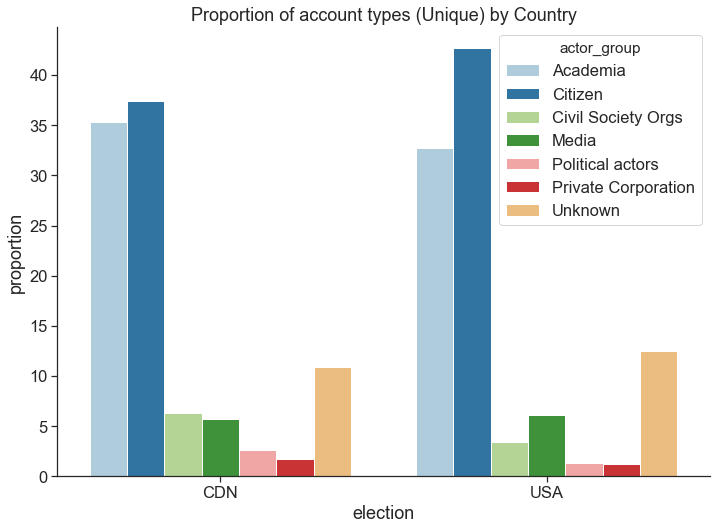

In [186]:
bars_by_country('actor_group')

In [88]:
dfa.groupby('is_retweet').size()

is_retweet
False    1117
True     1999
dtype: int64

### Top 10 most number of tweets overall

In [86]:
dfa.groupby(['screen_name', 'actor_group']).size().nlargest(10)

screen_name      actor_group       
ConversationEDU  Media                 68
ConversationUK   Media                 48
ConversationUS   Media                 44
RANDCorporation  Civil Society Orgs    33
DrRebeccaO       Citizen               22
TC_polsoc        Media                 21
KDFR1            Unknown               19
CMAJ_News        Academia              17
RebeccaAkao      Citizen               15
yoURDATAisyours  Citizen               14
dtype: int64

### Top 10 original tweeters

In [87]:
dfa[~dfa.is_retweet].groupby(['screen_name', 'actor_group']).size().nlargest(10)

screen_name      actor_group       
ConversationEDU  Media                 65
ConversationUK   Media                 46
ConversationUS   Media                 34
RANDCorporation  Civil Society Orgs    32
TC_polsoc        Media                 21
CMAJ_News        Academia              16
yoURDATAisyours  Citizen               14
suzlette333      Citizen               11
NatureNews       Media                 10
jenmercieca      Academia              10
dtype: int64

### Top 5 accounts in each group

(note top 2 Citizen accounts are actually same person, both accounts still active)

In [116]:
dfa.groupby(['actor_group', 'screen_name']).size().groupby(level=0, group_keys=False).nlargest(5)

actor_group          screen_name    
Academia             CMAJ_News          17
                     jenmercieca        10
                     trevortombe         9
                     EmeraldHSC          8
                     shaan_haan          8
Citizen              DrRebeccaO         22
                     RebeccaAkao        15
                     yoURDATAisyours    14
                     suzlette333        11
                     blueskies366        7
Civil Society Orgs   RANDCorporation    33
                     sev_agp             5
                     RI4A                3
                     AWHealthNetwork     2
                     AustBusinessNet     2
Media                ConversationEDU    68
                     ConversationUK     48
                     ConversationUS     44
                     TC_polsoc          21
                     NatureNews         10
Political actors     PracticallyGOP      7
                     SGIGreens           2
                 

### Top 5 most retweeted in each category

In [164]:
dfa.groupby(['actor_group_rt', 'retweet_of']).size().groupby(level=0, group_keys=False).nlargest(5)

actor_group_rt       retweet_of     
Academia             NEJM                95
                     CMAJ_News           50
                     muratbaday1         42
                     jenmercieca         17
                     OhioState           12
Citizen              DrRebeccaO          38
                     eatatjoe2           12
                     suzlette333          8
                     Aerin_J              7
                     Kind4Kids            6
Civil Society Orgs   RANDCorporation    114
                     Docs4refugeehc      15
                     E4Dca               11
                     PIPSC_science        8
                     VisionSuper          7
Media                NatureNews         575
                     ConversationEDU    318
                     ConversationUK     103
                     ConversationUS      57
                     picardonhealth      27
Political actors     SGIGreens           20
                     AniShakari        

In [195]:
def bars_who_rt_who(df, who_or_by='who', election=None):
    y = 'proportion'
    
    if who_or_by == 'who':
        x = 'actor_group'
        hue = 'actor_group_rt'
    else:
        x = 'actor_group_rt'
        hue = 'actor_group'

    if election:
        df = df[df.election == election]
    
    ax = (df.groupby([x, hue])
         .size().groupby(level=0).transform(lambda x: (100*x / x.sum()).round(2))
         .rename(y)
         .reset_index()
         .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))
    plt.ylim([0,80])
    
    locs, labels = plt.xticks()
    ax.set_xticklabels(['\n'.join(l.get_text().split(' ')) for l in labels], rotation=45)

    sns.despine(top=True, right=True)
    plt.legend(bbox_to_anchor=(.5, -.4), loc='upper center', borderaxespad=0., ncol=4)
    
    if who_or_by == 'who':    
        plt.title('Who Retweeted Who', fontsize=18)
    else:
        plt.title('Who Was Retweeted by Who', fontsize=18)
        
    plt.tight_layout()

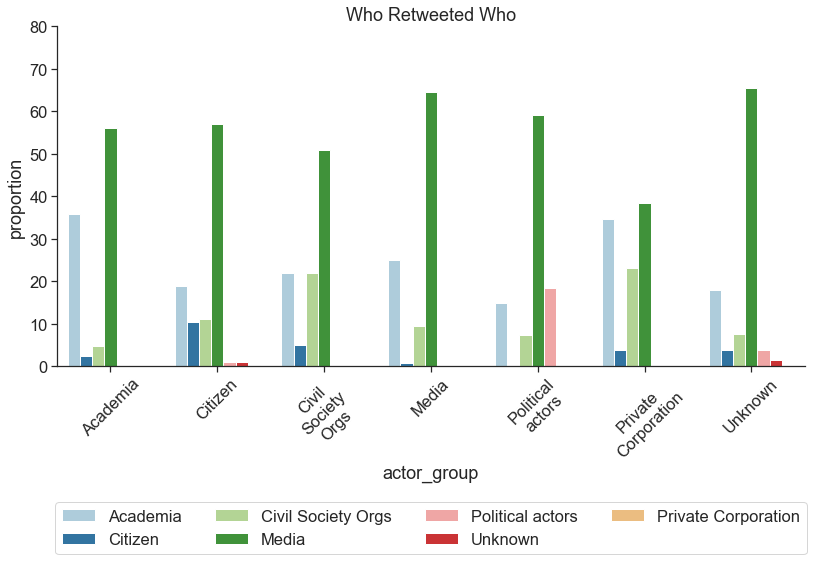

In [197]:
bars_who_rt_who(dfa, election='CDN')
plt.savefig('who_RTs_who_CDN.png')
plt.clf()

bars_who_rt_who(dfa, election='USA')
plt.savefig('who_RTs_who_USA.png')
plt.clf()

bars_who_rt_who(dfa)
plt.savefig('who_RTs_who.png')

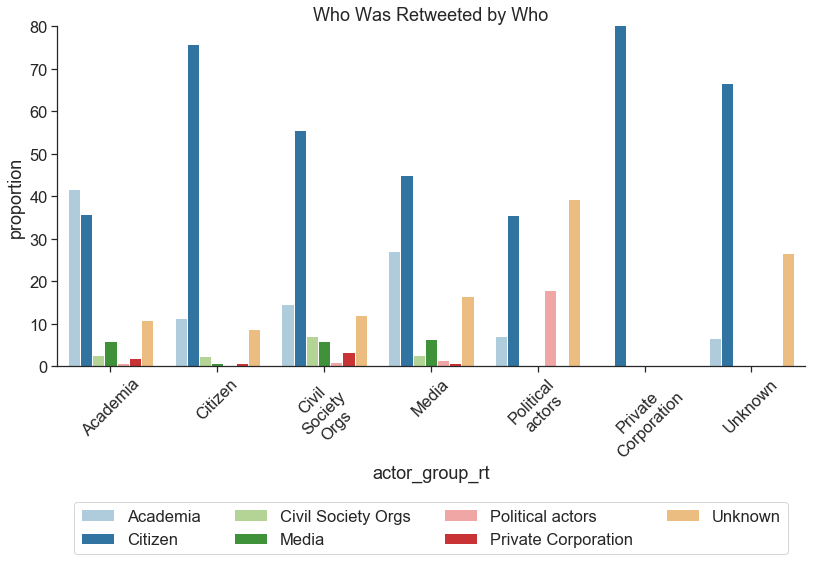

In [198]:
bars_who_rt_who(dfa, 'by', 'CDN')
plt.savefig('who_is_RTed_by_who_CDN.png')
plt.clf()

bars_who_rt_who(dfa, 'by', 'USA')
plt.savefig('who_is_RTed_by_who_USA.png')
plt.clf()

bars_who_rt_who(dfa, 'by')
plt.savefig('who_is_RTed_by_who_.png')

### Who tweets Nature News

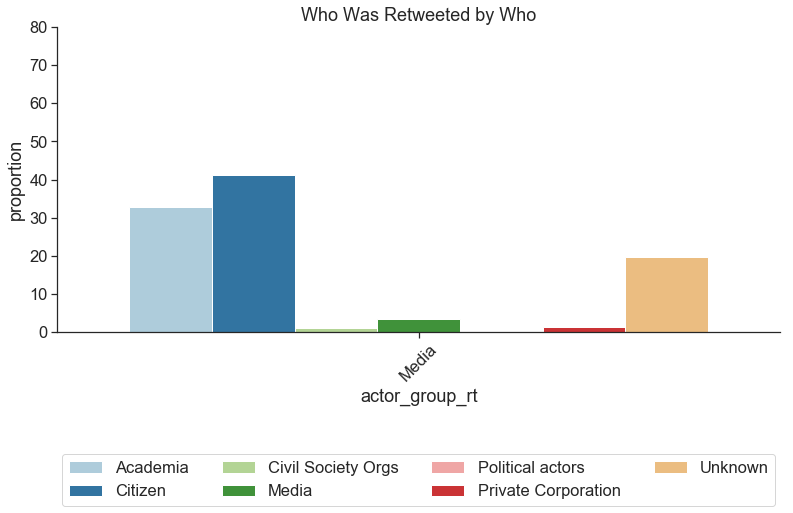

In [199]:
bars_who_rt_who(dfa[dfa.retweet_of=='NatureNews'], 'by')

### Who retweets The Conversation (all accounts)

(Note Unknown is different colour than elsewhere)

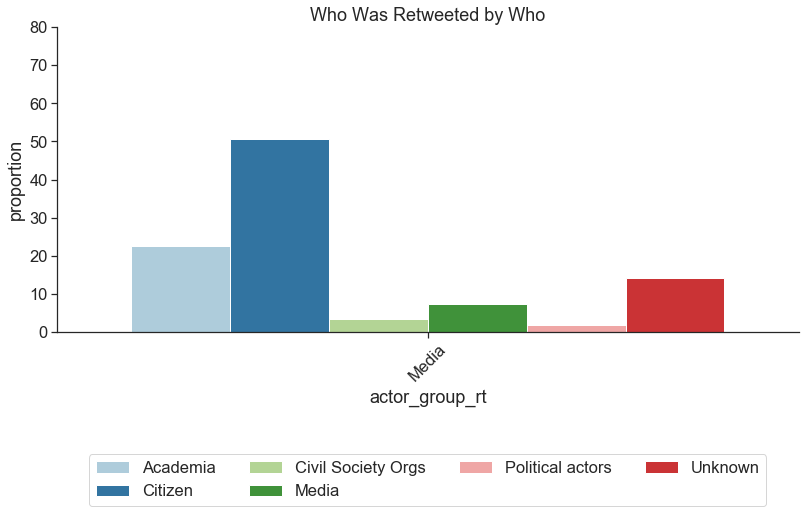

In [206]:
bars_who_rt_who(dfa[dfa.retweet_of.str.startswith('Conversation').map(bool)], 'by')